### Сравнение профилей Scalene для разных чисел потоков

Запускаем несколько повторов для каждого `--workers` (структура `profile/full_optim/wN/runM/profile.json`), собираем время/память, выводим средние и разброс (усиковые диаграммы).

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8')

PROFILE_ROOT = Path('profile/full_optim')
RUN_GLOB = 'w*'  # подпапки вида w1, w2, ...


In [2]:
def extract_profile_metrics(path: Path) -> dict:
    data = json.loads(path.read_text())
    return {
        'elapsed_sec': data.get('elapsed_time_sec') or 0,
        'max_footprint_mb': data.get('max_footprint_mb') or 0,
    }


def load_runs():
    rows = []
    for sub in sorted(PROFILE_ROOT.glob(RUN_GLOB), key=lambda p: int(p.name.lstrip('w') or 0)):
        # вариант без run*/profile.json (старый формат)
        direct_profile = sub / 'profile.json'
        if direct_profile.exists():
            metrics = extract_profile_metrics(direct_profile)
            workers = int(sub.name.lstrip('w') or 0)
            rows.append({'workers': workers, 'run': 1, 'profile_path': str(direct_profile), **metrics})
        # новый формат: run*/profile.json
        for run_dir in sorted(sub.glob('run*'), key=lambda p: int(p.name.lstrip('run') or 0)):
            profile_path = run_dir / 'profile.json'
            if not profile_path.exists():
                continue
            metrics = extract_profile_metrics(profile_path)
            workers = int(sub.name.lstrip('w') or 0)
            run_num = int(run_dir.name.lstrip('run') or 0)
            rows.append({'workers': workers, 'run': run_num, 'profile_path': str(profile_path), **metrics})
    if not rows:
        return pd.DataFrame(columns=['workers', 'run', 'profile_path', 'elapsed_sec', 'max_footprint_mb']).set_index('workers')
    return pd.DataFrame(rows).set_index('workers').sort_index()

df = load_runs()
display(df)

agg = (df.reset_index().groupby('workers')
         .agg(elapsed_sec_mean=('elapsed_sec','mean'),
              elapsed_sec_median=('elapsed_sec','median'),
              elapsed_sec_std=('elapsed_sec','std'),
              max_footprint_mb_mean=('max_footprint_mb','mean'),
              max_footprint_mb_median=('max_footprint_mb','median'),
              max_footprint_mb_std=('max_footprint_mb','std'))
        ) if not df.empty else pd.DataFrame()
display(agg)


,run,profile_path,elapsed_sec,max_footprint_mb
workers,,,,
1,1,profile/full_optim/w1/run1/profile.json,6.224500,32.917629
1,2,profile/full_optim/w1/run2/profile.json,4.545325,33.192124
1,3,profile/full_optim/w1/run3/profile.json,4.631038,36.590373
1,4,profile/full_optim/w1/run4/profile.json,4.613138,44.069112
1,5,profile/full_optim/w1/run5/profile.json,4.518128,45.431754
...,...,...,...,...
14,6,profile/full_optim/w14/run6/profile.json,2.269294,316.817978
14,7,profile/full_optim/w14/run7/profile.json,2.499798,392.010965
14,8,profile/full_optim/w14/run8/profile.json,3.778762,323.065931


,elapsed_sec_mean,elapsed_sec_median,elapsed_sec_std,max_footprint_mb_mean,max_footprint_mb_median,max_footprint_mb_std
workers,,,,,,
1,4.702644,4.534511,0.551587,39.994498,40.789092,5.917985
2,2.800776,2.806938,0.099042,53.601751,47.932854,11.757141
3,2.432620,2.401246,0.182795,81.065937,77.916916,14.302878
4,2.101941,2.058908,0.177270,95.489935,95.466227,16.154924
5,2.193083,2.125236,0.275257,118.040960,118.605001,23.809787
6,2.138709,1.991422,0.286142,138.994427,137.127893,23.287326
7,2.294955,2.162671,0.460359,168.328642,173.025036,28.550551
8,2.677421,2.331208,0.872741,199.495187,198.071698,23.993143
9,2.337503,2.256499,0.361610,220.092902,225.703249,33.346208


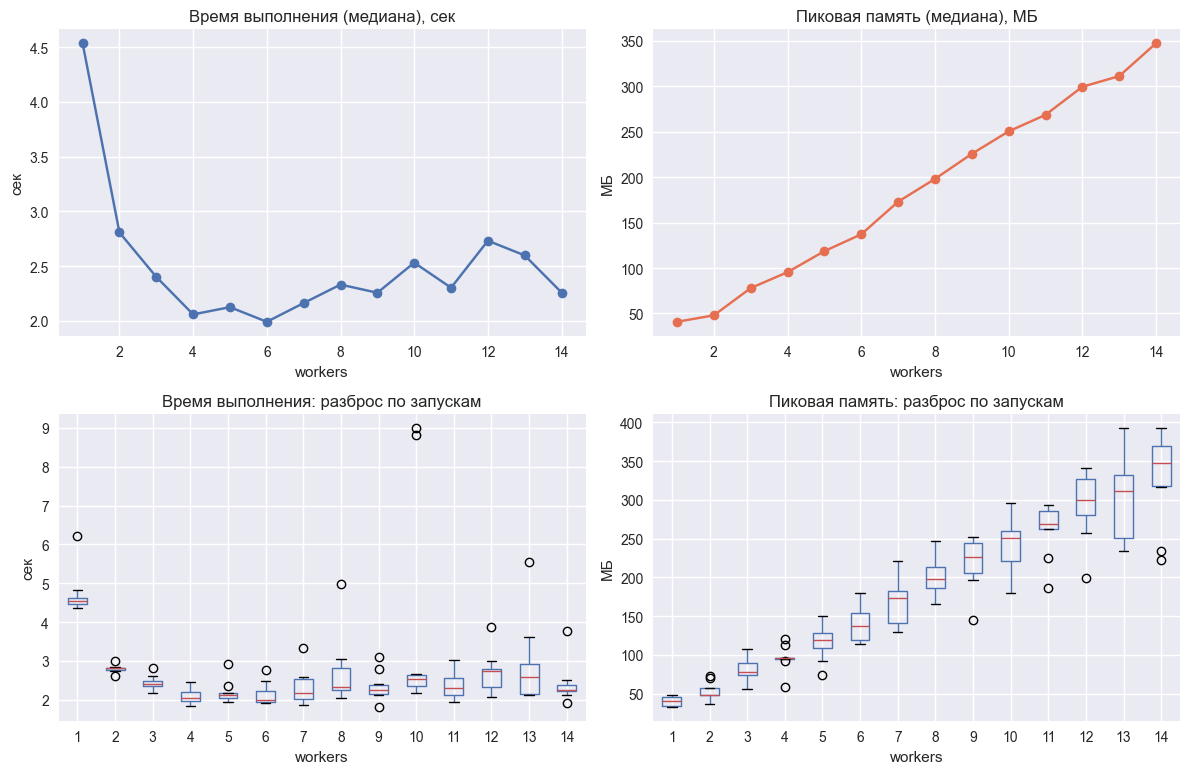

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

if df.empty:
    print('Нет данных: убедитесь, что профили лежат в profile/full_optim/w*/run*/profile.json')
else:
    if not agg.empty:
        agg['elapsed_sec_median'].plot(ax=axes[0, 0], marker='o')
        axes[0, 0].set_title('Время выполнения (медиана), сек')
        axes[0, 0].set_ylabel('сек')
        axes[0, 0].set_xlabel('workers')
        agg['max_footprint_mb_median'].plot(ax=axes[0, 1], marker='o', color='#e76f51')
        axes[0, 1].set_title('Пиковая память (медиана), МБ')
        axes[0, 1].set_ylabel('МБ')
        axes[0, 1].set_xlabel('workers')
    else:
        df['elapsed_sec'].plot(ax=axes[0, 0], marker='o')
        axes[0, 0].set_title('Время выполнения, сек')
        df['max_footprint_mb'].plot(ax=axes[0, 1], marker='o', color='#e76f51')
        axes[0, 1].set_title('Пиковая память, МБ')

    df.boxplot(column='elapsed_sec', by='workers', ax=axes[1, 0])
    axes[1, 0].set_title('Время выполнения: разброс по запускам')
    axes[1, 0].set_ylabel('сек')
    axes[1, 0].set_xlabel('workers')
    df.boxplot(column='max_footprint_mb', by='workers', ax=axes[1, 1])
    axes[1, 1].set_title('Пиковая память: разброс по запускам')
    axes[1, 1].set_ylabel('МБ')
    axes[1, 1].set_xlabel('workers')

plt.suptitle('')
plt.tight_layout()
plt.show()


In [4]:
if df.empty:
    print('Нет данных для сводки')
elif not agg.empty:
    best_time_w = agg['elapsed_sec_median'].idxmin()
    best_mem_w = agg['max_footprint_mb_median'].idxmin()
    print(f"Лучшая медиана времени: {best_time_w} worker(s) -> {agg.loc[best_time_w, 'elapsed_sec_median']:.3f} сек")
    print(f"Лучшая медиана памяти: {best_mem_w} worker(s) -> {agg.loc[best_mem_w, 'max_footprint_mb_median']:.1f} МБ")
else:
    print('Недостаточно данных для агрегации')


Лучшая медиана времени: 6 worker(s) -> 1.991 сек
Лучшая медиана памяти: 1 worker(s) -> 40.8 МБ
